<a href="https://colab.research.google.com/github/sheemambabu/CMPE-258-Deep-Learning/blob/main/Assignment%206/Assignment_6_Part_B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CMPE-258 Deep Learning**

## Assignment 6 Part B_1 - Keras

## By: Sheema Murugesh Babu (SJSU_ID: 015217176)

# Part B: Build an CNN based image classifier for Flowers Dataset

In [ ]:
!pip install kaggle

## Importing all the necessary libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"sheemamurugeshbabu","key":"dbef30ed61b5e48b9d63e529158a1a71"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download -d alxmamaev/flowers-recognition

flowers-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
ls -a

 ./    .config/   flowers-recognition.zip   kaggle.json
 ../   flowers/  'kaggle (1).json'          sample_data/


In [ ]:
!unzip flowers-recognition.zip

Streaming output truncated to the last 5000 lines.
  inflating: flowers/flowers/rose/110472418_87b6a3aa98_m.jpg  
  inflating: flowers/flowers/rose/11102341464_508d558dfc_n.jpg  
  inflating: flowers/flowers/rose/11233672494_d8bf0a3dbf_n.jpg  
  inflating: flowers/flowers/rose/11694025703_9a906fedc1_n.jpg  
  inflating: flowers/flowers/rose/118974357_0faa23cce9_n.jpg  
  inflating: flowers/flowers/rose/11944957684_2cc806276e.jpg  
  inflating: flowers/flowers/rose/12165480946_c4a3fe182d_n.jpg  
  inflating: flowers/flowers/rose/12202373204_34fb07205b.jpg  
  inflating: flowers/flowers/rose/12238827553_cf427bfd51_n.jpg  
  inflating: flowers/flowers/rose/12240165555_98625b1e88_n.jpg  
  inflating: flowers/flowers/rose/12240303_80d87f77a3_n.jpg  
  inflating: flowers/flowers/rose/12240577184_b0de0e53ea_n.jpg  
  inflating: flowers/flowers/rose/12243068283_ee4c2683e2_n.jpg  
  inflating: flowers/flowers/rose/12243069253_e512464095_n.jpg  
  inflating: flowers/flowers/rose/123128873_546b8b

In [ ]:
cd /content/flowers/flowers

/content/flowers/flowers


In [ ]:
ls -a

./  ../  daisy/  dandelion/  flowers/  rose/  sunflower/  tulip/


In [ ]:
from keras.preprocessing import image_dataset_from_directory

image_size = (180, 180)
batch_size = 32

train_ds = image_dataset_from_directory(
  "/content/flowers/flowers",
  validation_split=0.2,
  subset="training",
  seed=12,
  image_size=image_size,
  batch_size=batch_size 
  )

val_ds = image_dataset_from_directory(
  "/content/flowers/flowers",
  validation_split=0.2,
  subset="validation",
  seed=12,
  image_size=image_size,
  batch_size=batch_size 
  )

Found 8646 files belonging to 6 classes.
Using 6917 files for training.
Found 8646 files belonging to 6 classes.
Using 1729 files for validation.


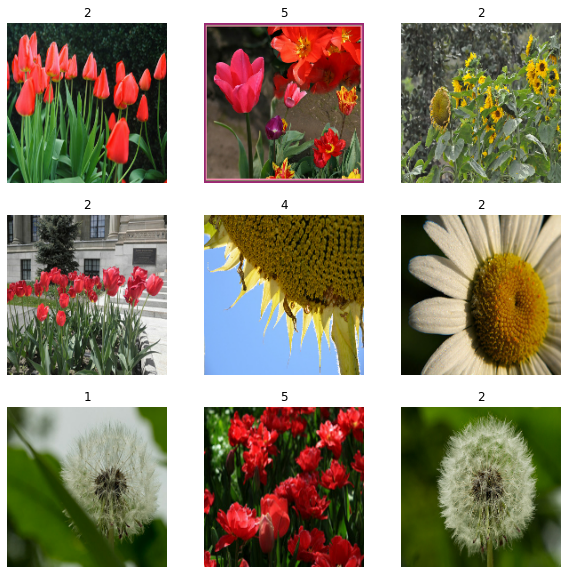

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

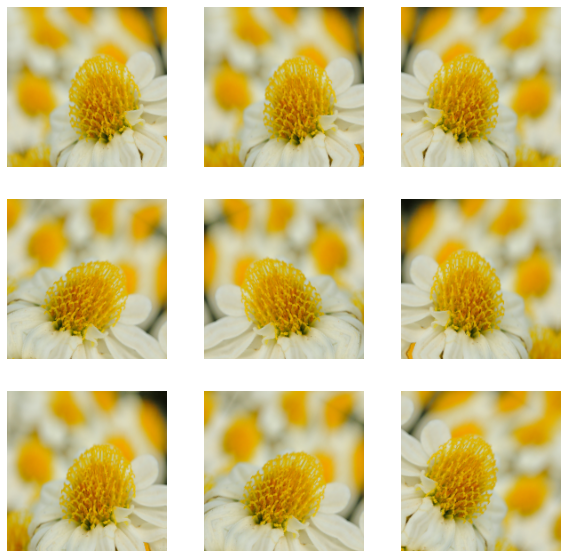

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

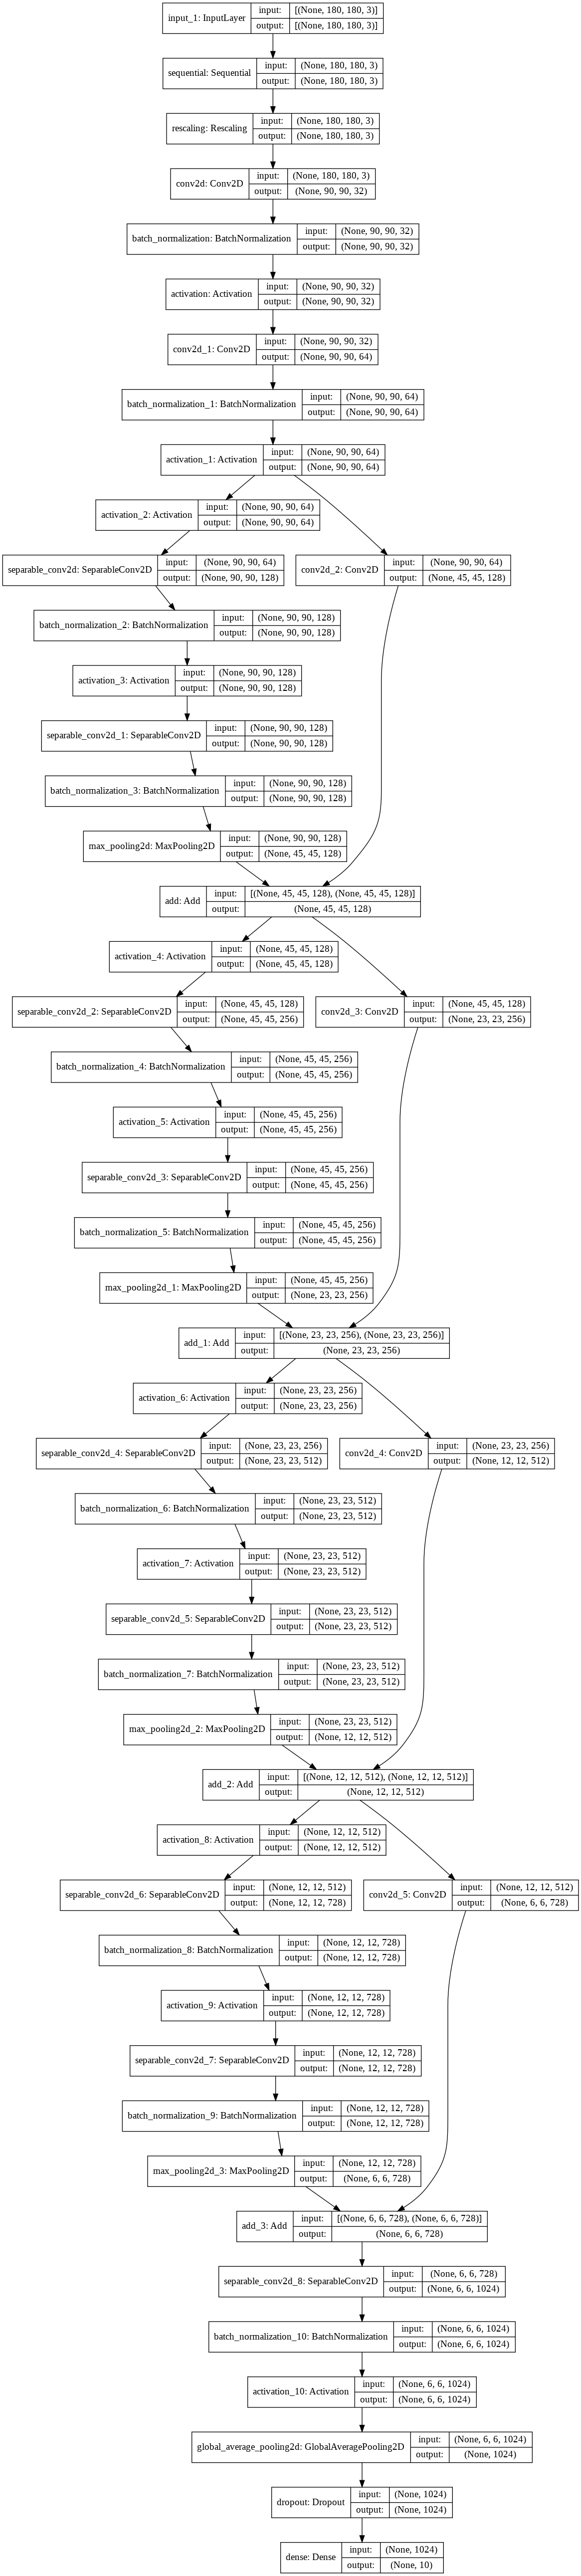

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=10)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/10
217/217 [==============================] - 103s 311ms/step - loss: 1.5687 - sparse_categorical_accuracy: 0.4460 - val_loss: 2.0220 - val_sparse_categorical_accuracy: 0.1238
Epoch 2/10
217/217 [==============================] - 67s 307ms/step - loss: 1.3601 - sparse_categorical_accuracy: 0.4645 - val_loss: 1.8835 - val_sparse_categorical_accuracy: 0.2238
Epoch 3/10
217/217 [==============================] - 68s 310ms/step - loss: 1.2668 - sparse_categorical_accuracy: 0.4844 - val_loss: 1.3633 - val_sparse_categorical_accuracy: 0.4586
Epoch 4/10
217/217 [==============================] - 68s 312ms/step - loss: 1.1954 - sparse_categorical_accuracy: 0.4855 - val_loss: 1.4325 - val_sparse_categorical_accuracy: 0.4627
Epoch 5/10
217/217 [==============================] - 68s 310ms/step - loss: 1.2023 - sparse_categorical_accuracy: 0.4836 - val_loss: 1.3376 - val_sparse_categorical_accuracy: 0.4650
Epoch 6/10
217/217 [==============================] - 68s 311ms/step - loss: 1.1589 

# Plotting

In [ ]:
def plots(losses, accuracies, subplot_title):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))

  ax1.plot(losses)
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title(subplot_title[0])

  ax2.plot(accuracies)
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title(subplot_title[1])

  plt.show()

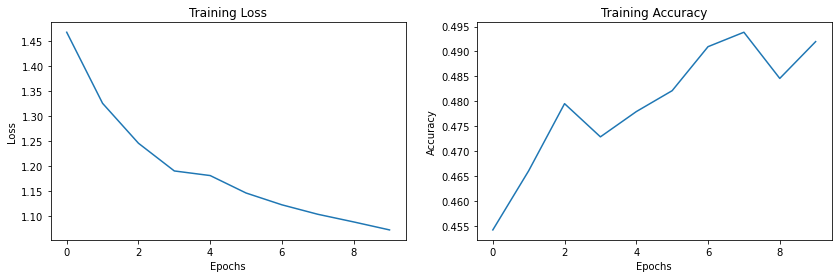

In [ ]:
# Training losses

plots(history.history['loss'], 
     history.history['sparse_categorical_accuracy'], 
     subplot_title=['Training Loss', 'Training Accuracy']
    )

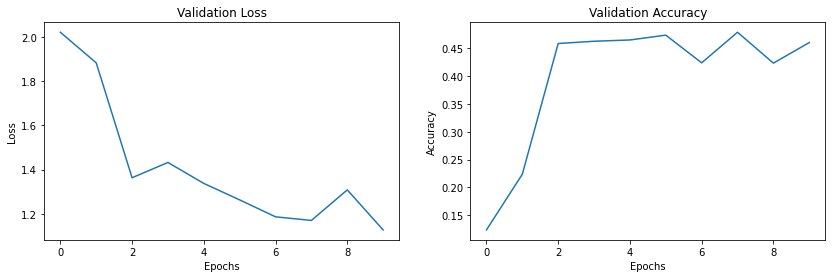

In [ ]:
# Validation losses

plots(history.history['val_loss'], 
     history.history['val_sparse_categorical_accuracy'], 
     subplot_title=['Validation Loss', 'Validation Accuracy']
    )

# References

1) https://keras.io/examples/vision/image_classification_from_scratch/#raw-data-download <br></br>

2)  https://www.kaggle.com/general/74235 <br></br>